In [1]:
# This is a learning notebook that try to reproduce this result from 
# "Using the latest advancements in AI to predict stock market movements": https://github.com/borisbanushev/stockpredictionai
# You may read the above link first for more details

# Data in /data are retrieved from: https://github.com/ivangundampc/stocknet-dataset

import time
import numpy as np
import pandas as pd

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

from statsmodels.tsa.arima_model import ARIMA

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

In [5]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

dataset_ex_df = pd.read_csv('../data/price/AAPL.csv', header=0, parse_dates=[0], date_parser=parser)

In [6]:
# Drop out unused columns
dataset_ex_df = dataset_ex_df.drop(['Open', 'High', 'Low', 'Adj Close'], axis=1)
dataset_ex_df = dataset_ex_df.rename({'Date': 'date', 'Close': 'price', 'Volume': 'volume'}, axis=1)

In [7]:
dataset_ex_df[['date', 'price']].head(3)

print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 1258 number of days in the dataset.


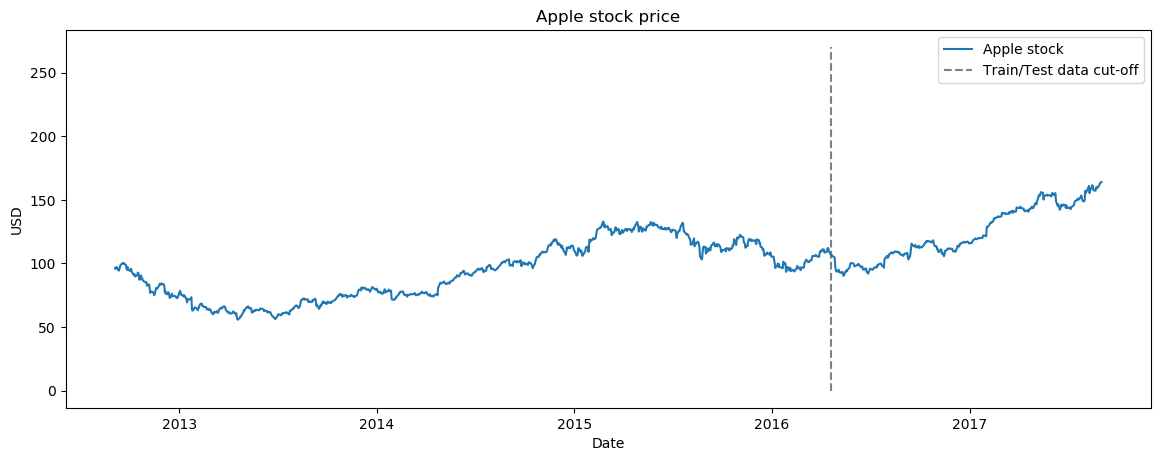

In [8]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['date'], dataset_ex_df['price'], label='Apple stock')
plt.vlines(datetime.date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Apple stock price')
plt.legend()
plt.show()

In [9]:
# Separating training / testing dataset
num_training_days = int(dataset_ex_df.shape[0]*.7)
num_testing_days = dataset_ex_df.shape[0]-num_training_days
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))

dataset_TI_df = dataset_ex_df[:num_training_days]
dataset_TE_df = dataset_ex_df[num_training_days:]
print(dataset_TI_df.shape)

Number of training days: 880. Number of test days: 378.
(880, 3)


In [10]:
# Calculate Technical indicators

def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['price'].rolling(window=7).mean()
    dataset['ma21'] = dataset['price'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = pd.ewma(dataset['price'], span=26)
    dataset['12ema'] = pd.ewma(dataset['price'], span=12)
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = pd.stats.moments.rolling_std(dataset['price'],20)
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['price'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['price']-1
    dataset['log_momentum'] = np.log(dataset['momentum'])
    
    return dataset

In [11]:
dataset_ex_df = get_technical_indicators(dataset_ex_df)
dataset_ex_df.tail()

,date,price,volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
1253,2017-08-28,161.470001,25966000,159.295715,157.902858,156.793205,159.092051,2.298846,2.731928,163.366714,152.439003,160.882052,160.470001,5.078107
1254,2017-08-29,162.910004,29516900,160.068573,158.578097,157.246302,159.679429,2.433127,2.116900,162.811897,154.344297,162.234020,161.910004,5.087041
1255,2017-08-30,163.350006,27269600,160.945716,159.211430,157.698428,160.244133,2.545705,2.278306,163.768042,154.654818,162.978011,162.350006,5.089755
1256,2017-08-31,164.000000,26785100,161.548573,159.538097,158.165211,160.821959,2.656748,2.328246,164.194589,154.881605,163.659337,163.000000,5.093750
1257,2017-09-01,164.050003,16552800,162.130003,159.941906,158.601122,161.318581,2.717459,2.378271,164.698448,155.185364,163.919781,163.050003,5.094057


In [12]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['price'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

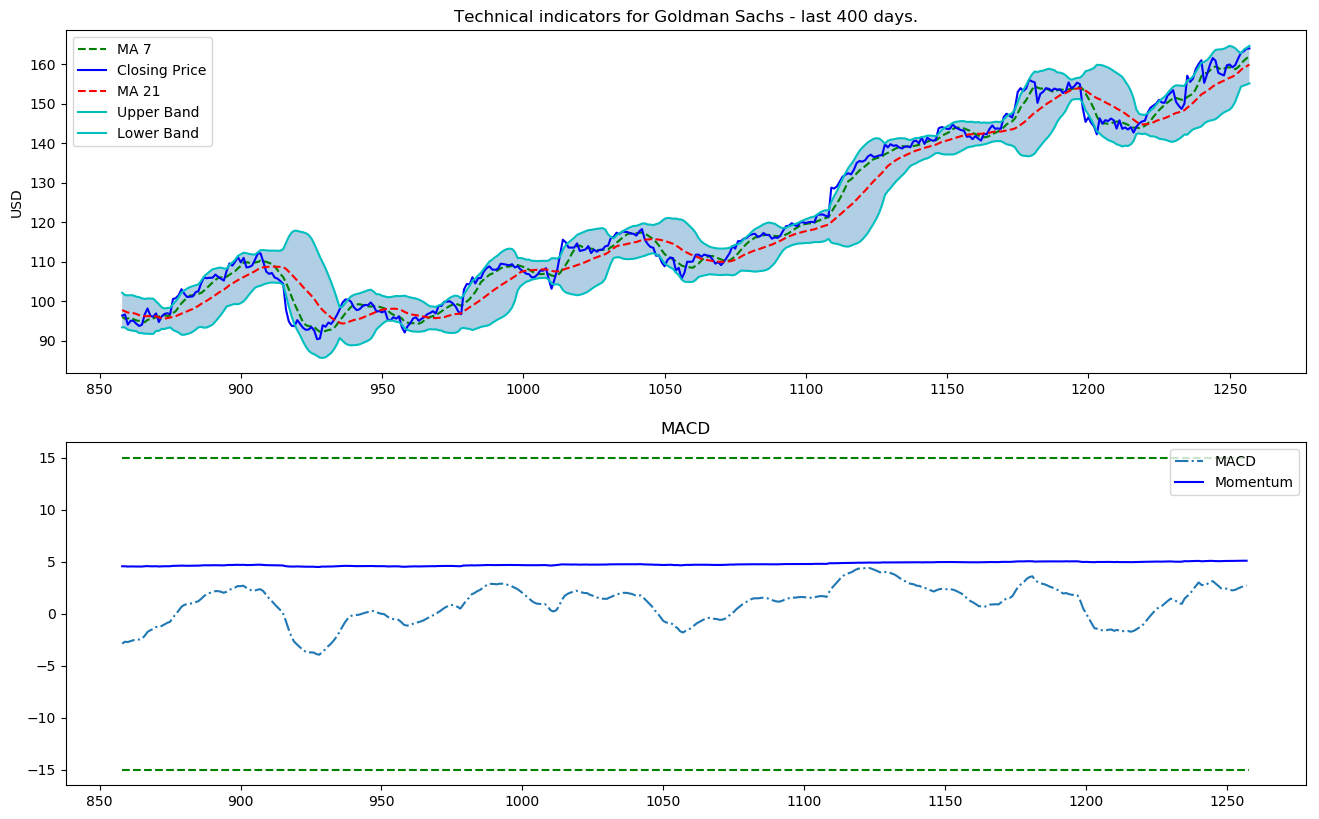

In [13]:
plot_technical_indicators(dataset_ex_df, 400)

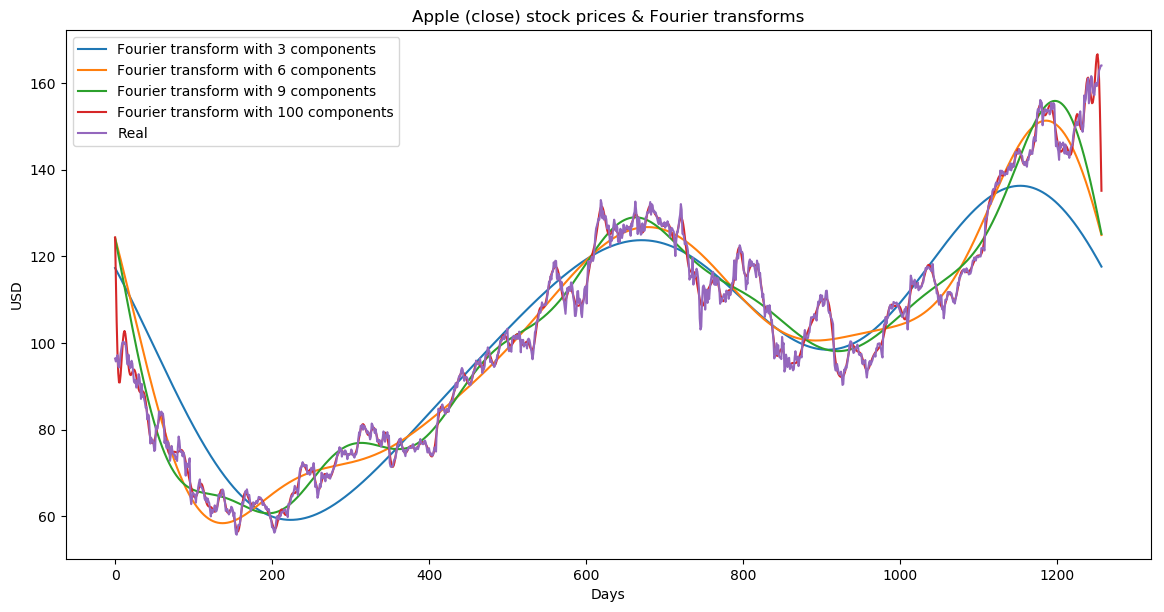

,date,price,volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,fourier3,fourier6,fourier9,fourier100
1253,2017-08-28,161.470001,25966000,159.295715,157.902858,156.793205,159.092051,2.298846,2.731928,163.366714,152.439003,160.882052,160.470001,5.078107,118.954805,127.618837,128.788161,164.890870
1254,2017-08-29,162.910004,29516900,160.068573,158.578097,157.246302,159.679429,2.433127,2.116900,162.811897,154.344297,162.234020,161.910004,5.087041,118.630485,126.957035,127.894863,160.700667
1255,2017-08-30,163.350006,27269600,160.945716,159.211430,157.698428,160.244133,2.545705,2.278306,163.768042,154.654818,162.978011,162.350006,5.089755,118.304076,126.289395,126.994215,154.063197
1256,2017-08-31,164.000000,26785100,161.548573,159.538097,158.165211,160.821959,2.656748,2.328246,164.194589,154.881605,163.659337,163.000000,5.093750,117.975612,125.616112,126.086716,145.324088
1257,2017-09-01,164.050003,16552800,162.130003,159.941906,158.601122,161.318581,2.717459,2.378271,164.698448,155.185364,163.919781,163.050003,5.094057,117.645131,124.937385,125.172873,135.139323


In [14]:
# Fourier transforms for trend analysis 
data_FT = dataset_ex_df[['date', 'price']]

close_fft = np.fft.fft(np.asarray(data_FT['price'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
    # Append columns to dataset
    dataset_ex_df['fourier{}'.format(num_)] = np.fft.ifft(fft_list_m10).astype(float)
    
plt.plot(data_FT['price'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Apple (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

dataset_ex_df.tail()

In [15]:
# ARIMA
series = data_FT['price']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 1257
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2326.654
Method:                       css-mle   S.D. of innovations              1.540
Date:                Wed, 20 Nov 2019   AIC                           4667.308
Time:                        16:59:16   BIC                           4703.263
Sample:                             1   HQIC                          4680.821
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0537      0.043      1.264      0.206      -0.030       0.137
ar.L1.D.price     0.0156      0.028      0.554      0.579      -0.040       0.071
ar.L2.D.price    -0.0358      0.028     

In [16]:
print('Total dataset has {} samples, and {} features.'.format(dataset_ex_df.shape[0], \
                                                              dataset_ex_df.shape[1]))

Total dataset has 1258 samples, and 18 features.


In [32]:
gan_num_features = dataset_ex_df.shape[1]
sequence_length = 17

class RNNModel(gluon.Block):
    def __init__(self, num_embed, num_hidden, num_layers, bidirectional=False, \
                 sequence_length=sequence_length, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.num_hidden = num_hidden
        with self.name_scope():
            self.rnn = rnn.LSTM(num_hidden, num_layers, input_size=num_embed, \
                                bidirectional=bidirectional, layout='TNC')
            
            self.decoder = nn.Dense(1, in_units=num_hidden)
    
    def forward(self, inputs, hidden):
        output, hidden = self.rnn(inputs, hidden)
        decoded = self.decoder(output.reshape((-1, self.num_hidden)))
        return decoded, hidden
    
    def begin_state(self, *args, **kwargs):
        return self.rnn.begin_state(*args, **kwargs)
    
lstm_model = RNNModel(num_embed=gan_num_features, num_hidden=500, num_layers=1)
lstm_model.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())
trainer = gluon.Trainer(lstm_model.collect_params(), 'adam', {'learning_rate': .01})
loss = gluon.loss.L1Loss()

RNNModel(
  (rnn): LSTM(18 -> 500, TNC)
  (decoder): Dense(500 -> 1, linear)
)
